EDA

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

Loading all datasets using multiprocessing. This speads up a process a bit.

In [2]:
files = ['../input/test_identity.csv', 
         '../input/test_transaction.csv',
         '../input/train_identity.csv',
         '../input/train_transaction.csv',
         '../input/sample_submission.csv']

In [3]:
%%time
def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

CPU times: user 3.4 s, sys: 8.61 s, total: 12 s
Wall time: 55 s


In [4]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect();

In [5]:
def plot_numerical(feature):
    """
    Plot some information about a numerical feature for both train and test set.
    Args:
        feature (str): name of the column in DataFrame
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    sns.kdeplot(train[feature], ax=axes[0][0], label='Train');
    sns.kdeplot(test[feature], ax=axes[0][0], label='Test');

    sns.kdeplot(train[train['isFraud']==0][feature], ax=axes[0][1], label='isFraud 0')
    sns.kdeplot(train[train['isFraud']==1][feature], ax=axes[0][1], label='isFraud 1')

    test[feature].index += len(train)
    axes[1][0].plot(train[feature], '.', label='Train');
    axes[1][0].plot(test[feature], '.', label='Test');
    axes[1][0].set_xlabel('row index');
    axes[1][0].legend()
    test[feature].index -= len(train)

    axes[1][1].plot(train[train['isFraud']==0][feature], '.', label='isFraud 0');
    axes[1][1].plot(train[train['isFraud']==1][feature], '.', label='isFraud 1');
    axes[1][1].set_xlabel('row index');
    axes[1][1].legend()

    pd.DataFrame({'train': [train[feature].isnull().sum()], 'test': [test[feature].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[2][0]);
    pd.DataFrame({'isFraud 0': [train[(train['isFraud']==0) & (train[feature].isnull())][feature].shape[0]],
                  'isFraud 1': [train[(train['isFraud']==1) & (train[feature].isnull())][feature].shape[0]]}).plot(kind='bar', rot=0, ax=axes[2][1]);

    fig.suptitle(feature, fontsize=18);
    axes[0][0].set_title('Train/Test KDE distribution');
    axes[0][1].set_title('Target value KDE distribution');
    axes[1][0].set_title('Index versus value: Train/Test distribution');
    axes[1][1].set_title('Index versus value: Target distribution');
    axes[2][0].set_title('Number of NaNs');
    axes[2][1].set_title('Target value distribution among NaN values');

# Transaction DT


So lets transform TransactionDT into a datetime.

In [6]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

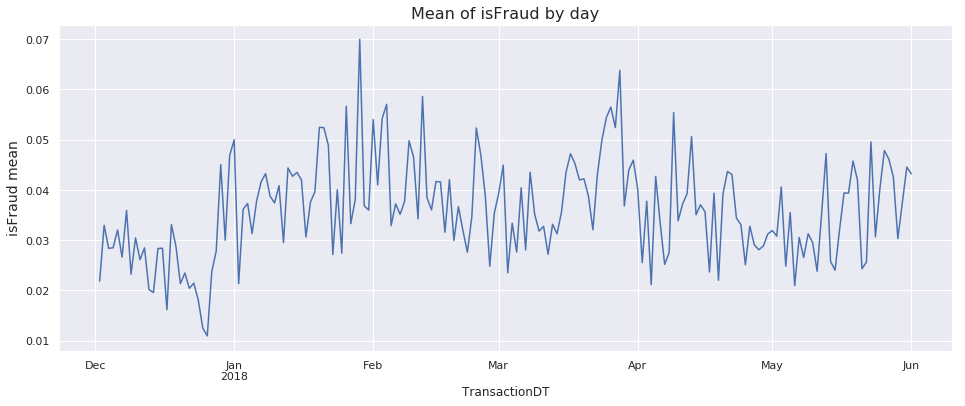

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by day', fontsize=16);

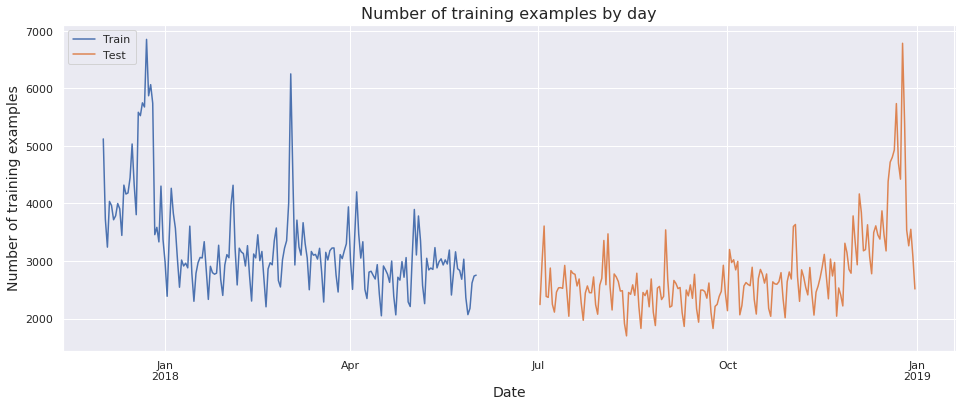

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of training examples', fontsize=14);
axes.set_title('Number of training examples by day', fontsize=16);
axes.legend(['Train', 'Test']);

And now combining both mean of isFraud by day and number of training examples by day into a single plot.

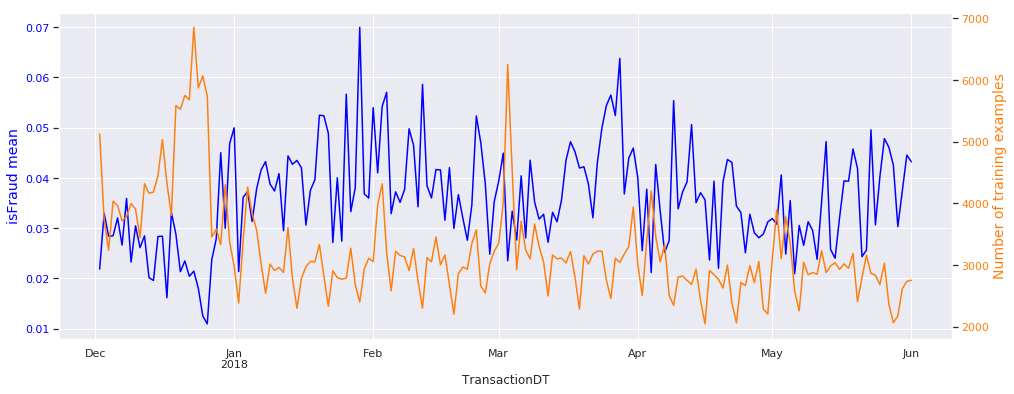

In [9]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean', color='blue', fontsize=14)
ax2 = ax1.twinx()
train['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=ax2, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Number of training examples', color='tab:orange', fontsize=14);
ax2.grid(False)

# card1
I have decided to start from one of the most important features of this dataset according to LightGBM feature_importance. And **card1** is one of those features.


In [10]:
y = train['isFraud']
X = pd.DataFrame()
X['card1'] = train['card1']
X['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.548645816796713


So if we train a simple decision tree, using this two features we have an AUC slightly higher that 0.5. Let's see why by plotting this tree as a graph

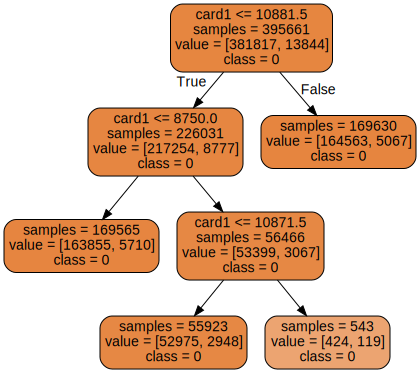

In [12]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = X.columns, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)

The first split is by the values less than or equal to 10881.5 (black line) and the second one is 8750.0 (red line) and a tree does not use a count feature at all.

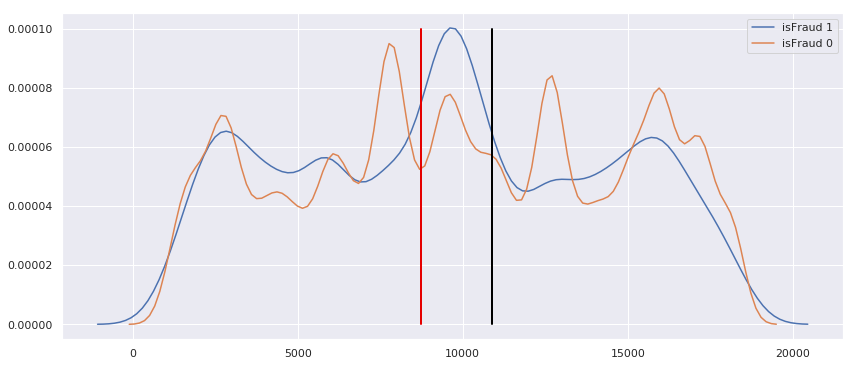

In [13]:
plt.figure(figsize=(14, 6))
sns.kdeplot(X[y==1]['card1'], label='isFraud 1');
sns.kdeplot(X[y==0]['card1'], label='isFraud 0');
plt.plot([10881.5, 10881.5], [0.0000, 0.0001], sns.xkcd_rgb["black"], lw=2);
plt.plot([8750.0, 8750.0], [0.0000, 0.0001], sns.xkcd_rgb["red"], lw=2);

But lets take a little step back and train a boosting model on only one original feature card1

In [14]:
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X['card1'], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

ROC AUC score 0.6929916198705168


This is a heatmap with a probability of isFraud=1 for every unique value in the **card1** feature.

This picture reminds me an opening from a Total Recall movie. 

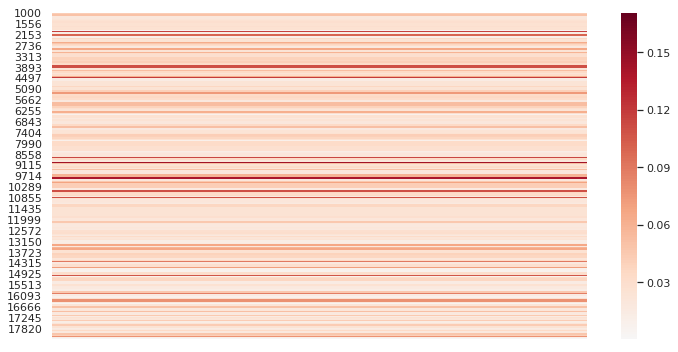

In [15]:
plt.figure(figsize=(12, 6))
x = clf.predict_proba(X['card1'].sort_values().unique().reshape(-1, 1))[:, 1]
x = pd.Series(x, index=X['card1'].sort_values().unique())
sns.heatmap(x.to_frame(), cmap='RdBu_r', center=0.0);
plt.xticks([]);

Now lets add a second feature - count encoded **card1** values.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7677377885485746


Holdout score has significantly increased. Lets create another heatmap and see why. 

There are some darker spots in some intersections of the variable **card1** values and it's count encoded values. This is the reason of the holdout score improvement.

*The image is pre-rendered since rendering takes some significant amount of time*

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1696976%2F7153f1242daa586d6849c83242c3fe40%2F35267aee89a7552caf082b6bb0039aa5-full.png?generation=1564585074348507&alt=media)

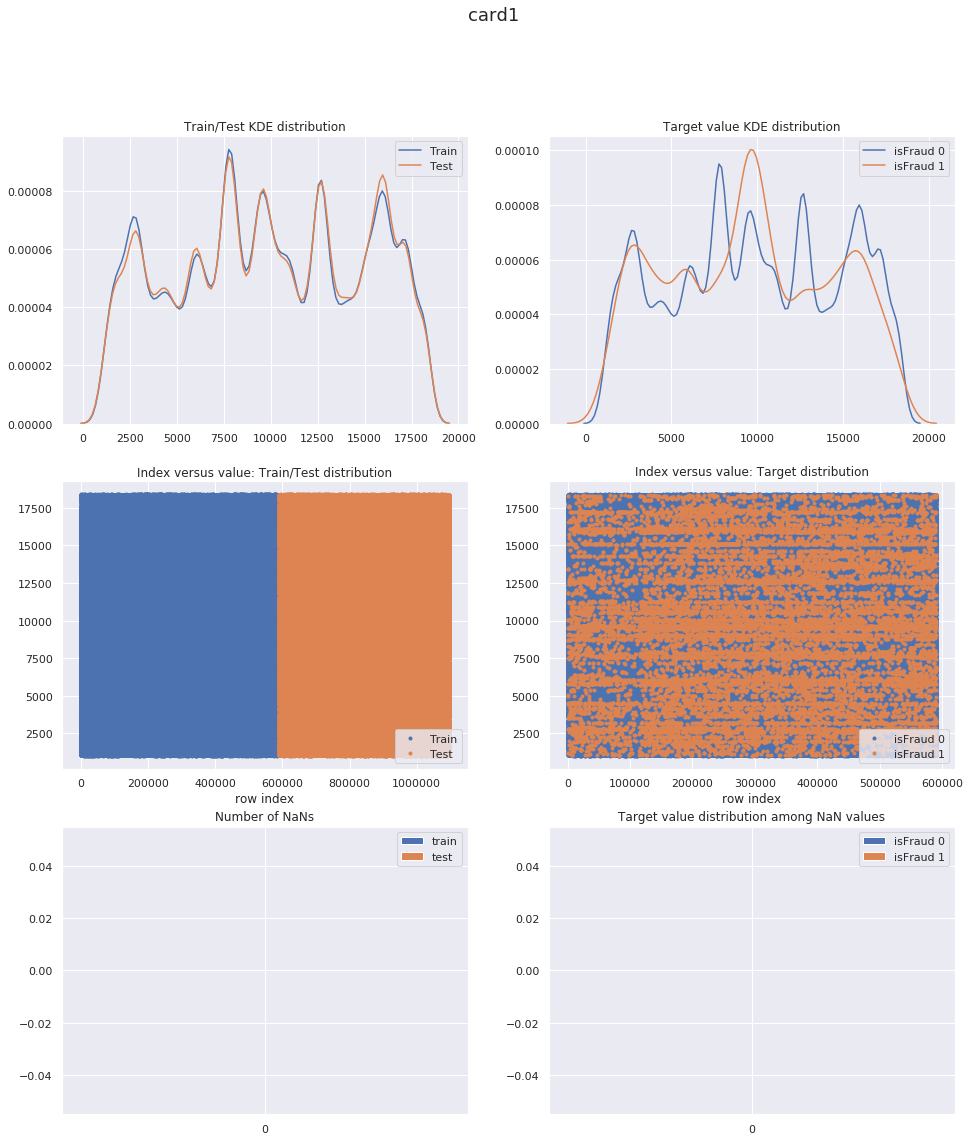

In [17]:
plot_numerical('card1')

Plotting this variable gives us such information as:
* distribution in train and test set is almost equal.
* distribution between target values differs, which make this feature so valuable
* this feature doesn't have any NaNs

Lets check a Covariate Shift of the feature. This means that we will try to distinguish whether a values correspond to a training set or to a testing set.

In [18]:
# Creating two new dataframes with only 1 feature: card1 and a label isTest, which indicates whether a training example correspond to train or test set
df_card1_train = pd.DataFrame(data={'card1': train['card1'], 'isTest': 0})
df_card1_test = pd.DataFrame(data={'card1': test['card1'], 'isTest': 1})

# Creating a single dataframe
df = pd.concat([df_card1_train, df_card1_test], ignore_index=True)

# Splitting it to a training and testing set
X_train, X_test, y_train, y_test = train_test_split(df['card1'], df['isTest'], test_size=0.33, random_state=47, stratify=df['isTest'])

clf = lgb.LGBMClassifier(**params, num_boost_round=500)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

del df, X_train, y_train, X_test, y_test
gc.collect();

ROC AUC score: 0.5396478567335838


ROC AUC score is close to 0.5, this means that this feature almost does not have any shift between train and test and is definitely worth keeping it.

# ProductCD

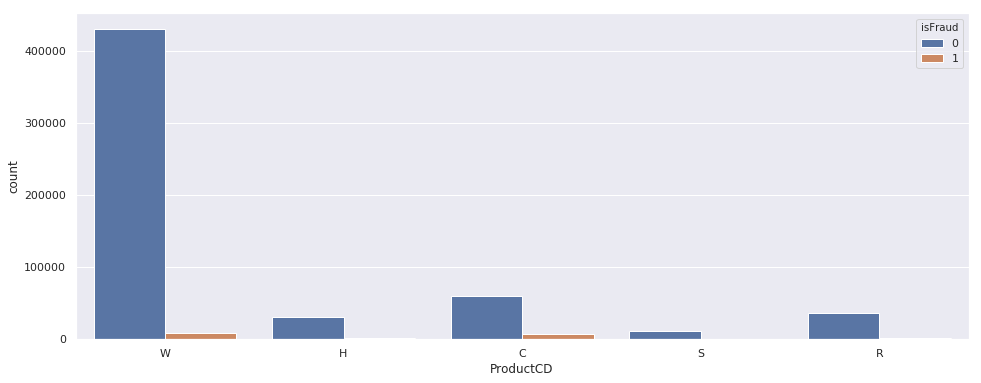

In [19]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train, x='ProductCD', hue='isFraud');

# addr1 

Another feature with a relatively high importance is **addr1**. According to the name of the feature we can assume that it contains some kind of users address, but in an encoded way. Also this time a feature have some missing values. We are going to fill them with 0.

In [20]:
y = train['isFraud']
X = pd.DataFrame()
X['addr1'] = train['addr1']
X['addr1_count'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
X['addr1'].fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X['addr1'], y, test_size=0.33, random_state=47)
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

ROC AUC score: 0.6384265775760748


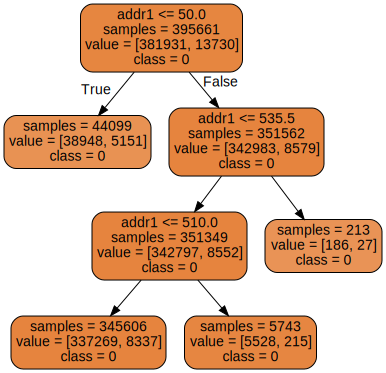

In [21]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['addr1'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)

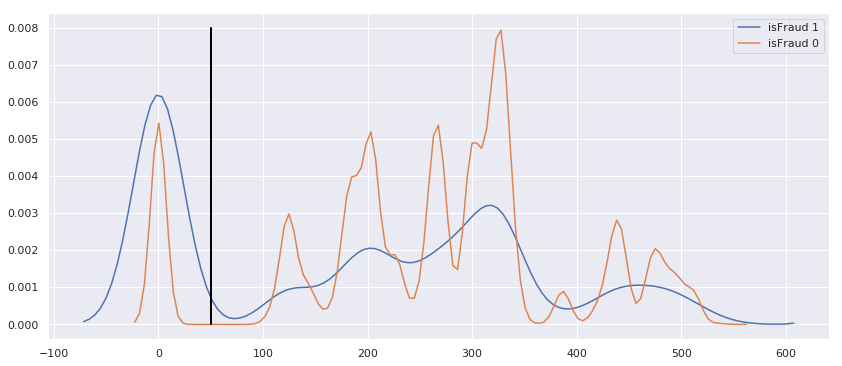

In [22]:
plt.figure(figsize=(14, 6))
sns.kdeplot(X[y==1]['addr1'], label='isFraud 1');
sns.kdeplot(X[y==0]['addr1'], label='isFraud 0');
plt.plot([50.0, 50.0], [0.0000, 0.008], sns.xkcd_rgb["black"], lw=2);

Again training a gradient boosting model with only one feature.

In [23]:
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X['addr1'], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

ROC AUC score: 0.6855464245988521


Predictions heatmap.

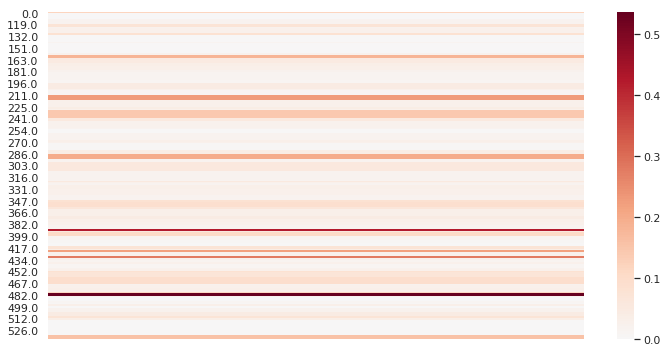

In [24]:
plt.figure(figsize=(12, 6))
x = clf.predict_proba(X['addr1'].sort_values().unique().reshape(-1, 1))[:, 1]
x = pd.Series(x, index=X['addr1'].sort_values().unique())
sns.heatmap(x.to_frame(), cmap='RdBu_r', center=0.0);
plt.xticks([]);

So far we are doing exactly the same thing that we have been doing for the previous variable.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.68584123437748


In [26]:
result_df = pd.DataFrame()

for i in X['addr1'].sort_values().unique():
    x = pd.DataFrame()
    x['addr1'] = [i] * X['addr1_count'].nunique()
    x['addr1_count'] = X['addr1_count'].sort_values().unique()
    
    result_df = pd.concat([result_df, x], axis=0)

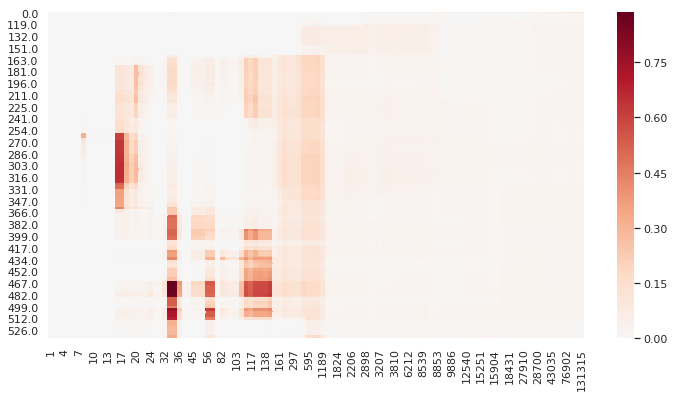

In [27]:
preds = clf.predict_proba(result_df)[:, 1]
preds = preds.reshape(X['addr1'].nunique(), X['addr1_count'].nunique())
preds = pd.DataFrame(preds, index=X['addr1'].sort_values().unique(), columns=X['addr1_count'].sort_values().unique())

plt.figure(figsize=(12, 6))
sns.heatmap(preds, cmap='RdBu_r', center=0.0);

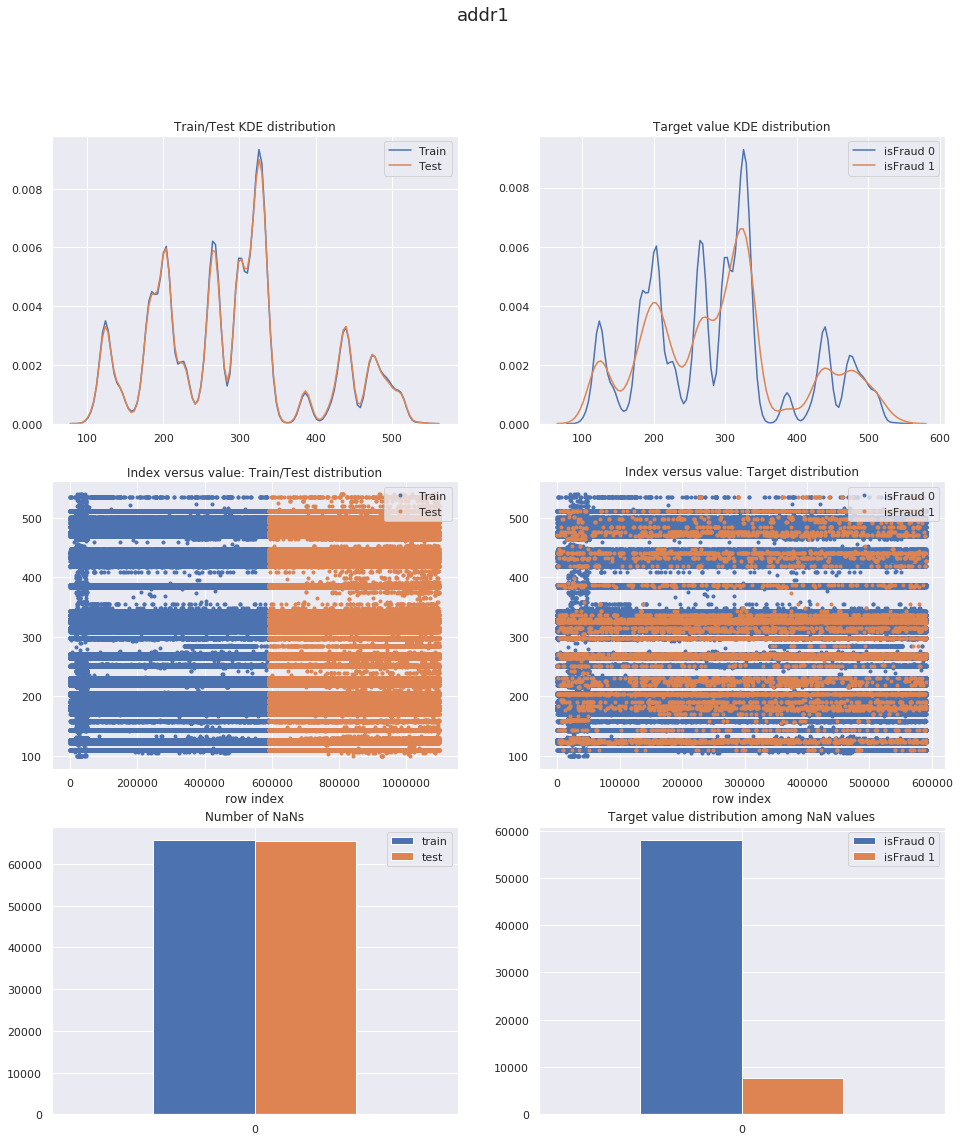

In [28]:
plot_numerical('addr1')

Distribution is the same, amount of NaN's is the same. Some difference in target value distribution. 

Next checking Covariate Shift for addr1.

In [29]:
def covariate_shift(feature):
    df_card1_train = pd.DataFrame(data={feature: train[feature], 'isTest': 0})
    df_card1_test = pd.DataFrame(data={feature: test[feature], 'isTest': 1})

    # Creating a single dataframe
    df = pd.concat([df_card1_train, df_card1_test], ignore_index=True)
    
    # Encoding if feature is categorical
    if str(df[feature].dtype) in ['object', 'category']:
        df[feature] = LabelEncoder().fit_transform(df[feature].astype(str))
    
    # Splitting it to a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(df[feature], df['isTest'], test_size=0.33, random_state=47, stratify=df['isTest'])

    clf = lgb.LGBMClassifier(**params, num_boost_round=500)
    clf.fit(X_train.values.reshape(-1, 1), y_train)
    roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del df, X_train, y_train, X_test, y_test
    gc.collect();
    
    return roc_auc

In [30]:
print('ROC AUC score:', covariate_shift('addr1'))

ROC AUC score: 0.5216072351375447


ROC AUC score is close to 0.5

This feature also does not have any shift between train and test set.

# card1 to addr1 interaction

Next I am going to create a new feature out of this two features interaction and train on the result.

In [31]:
X = pd.DataFrame()
X['addr1'] = train['addr1']
X['card1'] = train['card1']
y = train['isFraud']
X['addr1'].fillna(0, inplace=True)

X['addr1_card1'] = X['addr1'].astype(str) + '_' + X['card1'].astype(str)
X['addr1_card1'] = LabelEncoder().fit_transform(X['addr1_card1'])

First training a model only using this two features, without their interaction.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X[['addr1', 'card1']], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.784380872912713

And now WITH interaction

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X[['addr1', 'card1', 'addr1_card1']], y, test_size=0.33, random_state=47, stratify=y)
clf1 = lgb.LGBMClassifier(**params)
clf1.fit(X_train, y_train)
roc_auc_score(y_test, clf1.predict_proba(X_test)[:, 1])

0.7868034424617317

In [34]:
result_df = pd.DataFrame()

for i in tqdm_notebook(X['addr1'].sort_values().unique()):
    x = pd.DataFrame()
    x['addr1'] = [i] * X['card1'].nunique()
    x['card1'] = X['card1'].sort_values().unique()
    
    result_df = pd.concat([result_df, x], axis=0)

Predictions heatmap of the two features interaction.

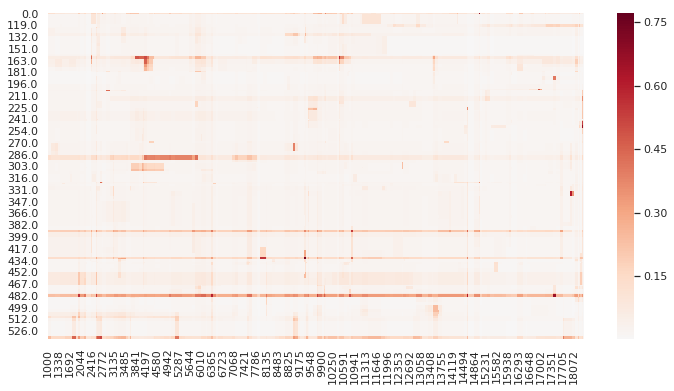

In [35]:
preds = clf.predict_proba(result_df)[:, 1]
preds = preds.reshape(X['addr1'].nunique(), X['card1'].nunique())
preds = pd.DataFrame(preds, index=X['addr1'].sort_values().unique(), columns=X['card1'].sort_values().unique())
plt.figure(figsize=(12, 6))
sns.heatmap(preds, cmap='RdBu_r', center=0.0);

Finally adding count features, so all in all we have 5 features

In [36]:
X['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
X['addr1_count'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.8079847404025295

# New feature: number of NaN's
We have plenty of NaN's in this dataset and they can have a significant effect so why don't we use them?
I am adding a new column to the dateset, which will contain a number of NaN for each row. So if a row (a single training example) contain, say, 10 NaNs, a new feature's value for this row will be 10.

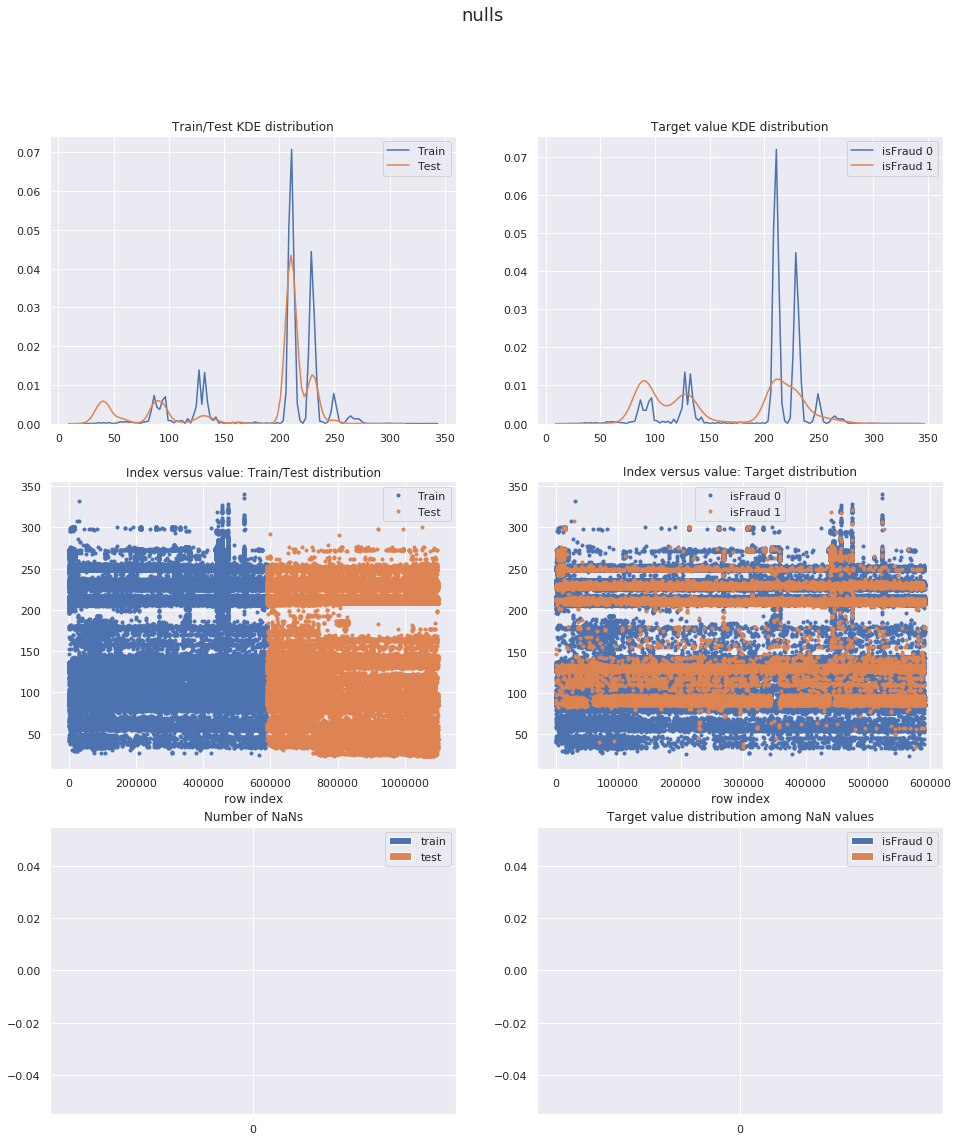

In [38]:
train['nulls'] = train.isnull().sum(axis=1)
test['nulls'] = test.isnull().sum(axis=1)
plot_numerical('nulls')

In [39]:
print('Covariant shift ROC AUC:', covariate_shift('nulls'))

Covariant shift ROC AUC: 0.690769942059486


We can see that this feature might be useful, but also keep in mind that covatiate shift is almost 0.7, which tells us that the distribution between train and test set has some difference.

# TransactionAmt and it's decimal part

First let's take a look at TransactionAmt feature and them I will create a new one - it's decimal part, which is a very popular way of creating a new features.

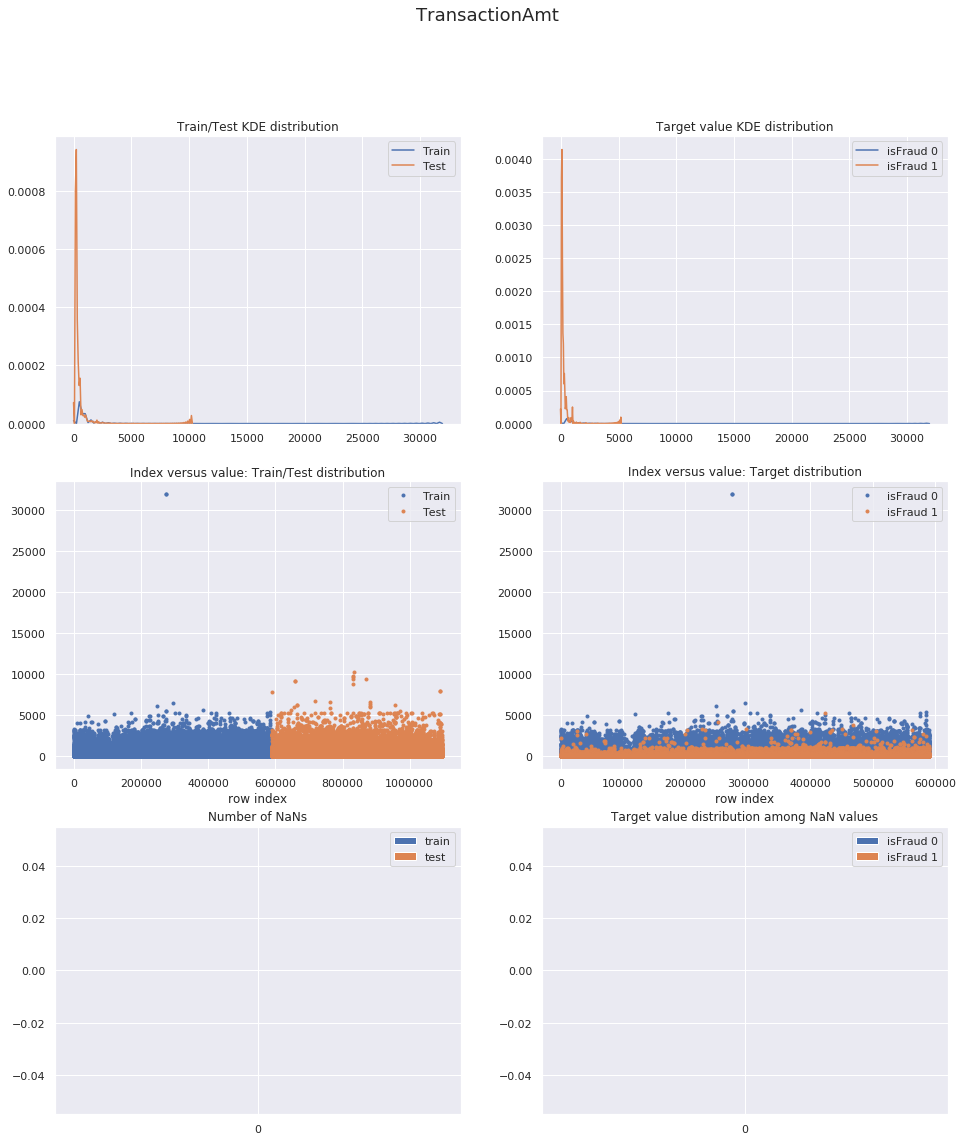

In [40]:
plot_numerical('TransactionAmt')

Moving average for TransactionAmt over time.

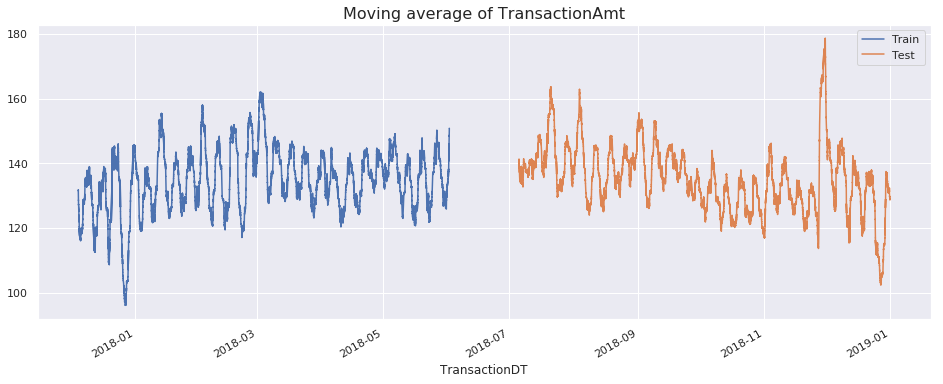

In [41]:
fig, axes = plt.subplots(1,1,figsize=(16, 6))
axes.set_title('Moving average of TransactionAmt', fontsize=16);
train[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes);
test[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes);
axes.legend(['Train', 'Test']);

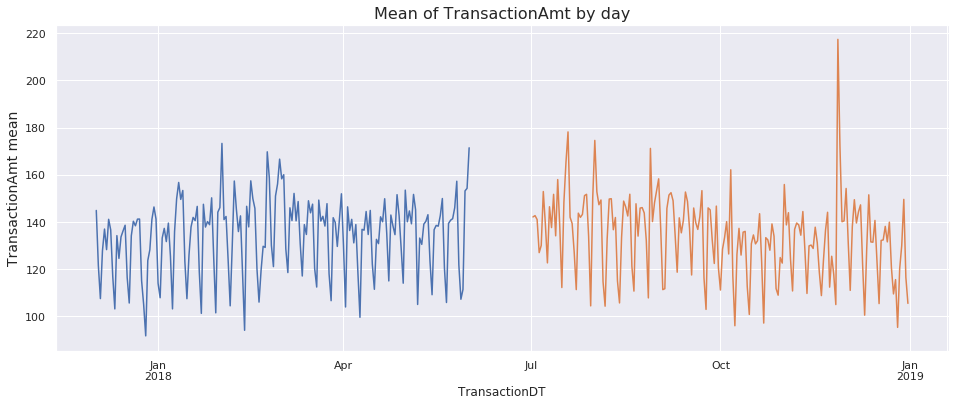

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes).set_ylabel('TransactionAmt mean', fontsize=14);
test.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes).set_ylabel('TransactionAmt mean', fontsize=14);
axes.set_title('Mean of TransactionAmt by day', fontsize=16);

A relationship between mean of TransactionAmt by day and a mean of isFraud by day.

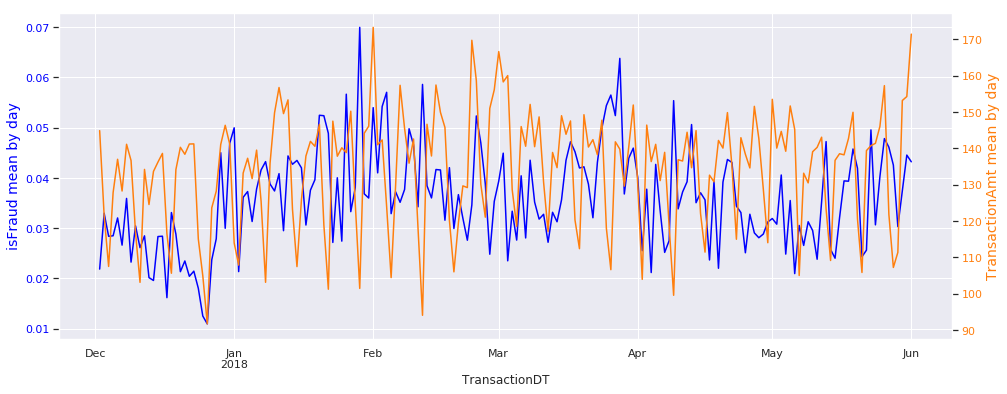

In [43]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean by day', color='blue', fontsize=14)
ax2 = ax1.twinx()
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=ax2, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('TransactionAmt mean by day', color='tab:orange', fontsize=14);
ax2.grid(False)

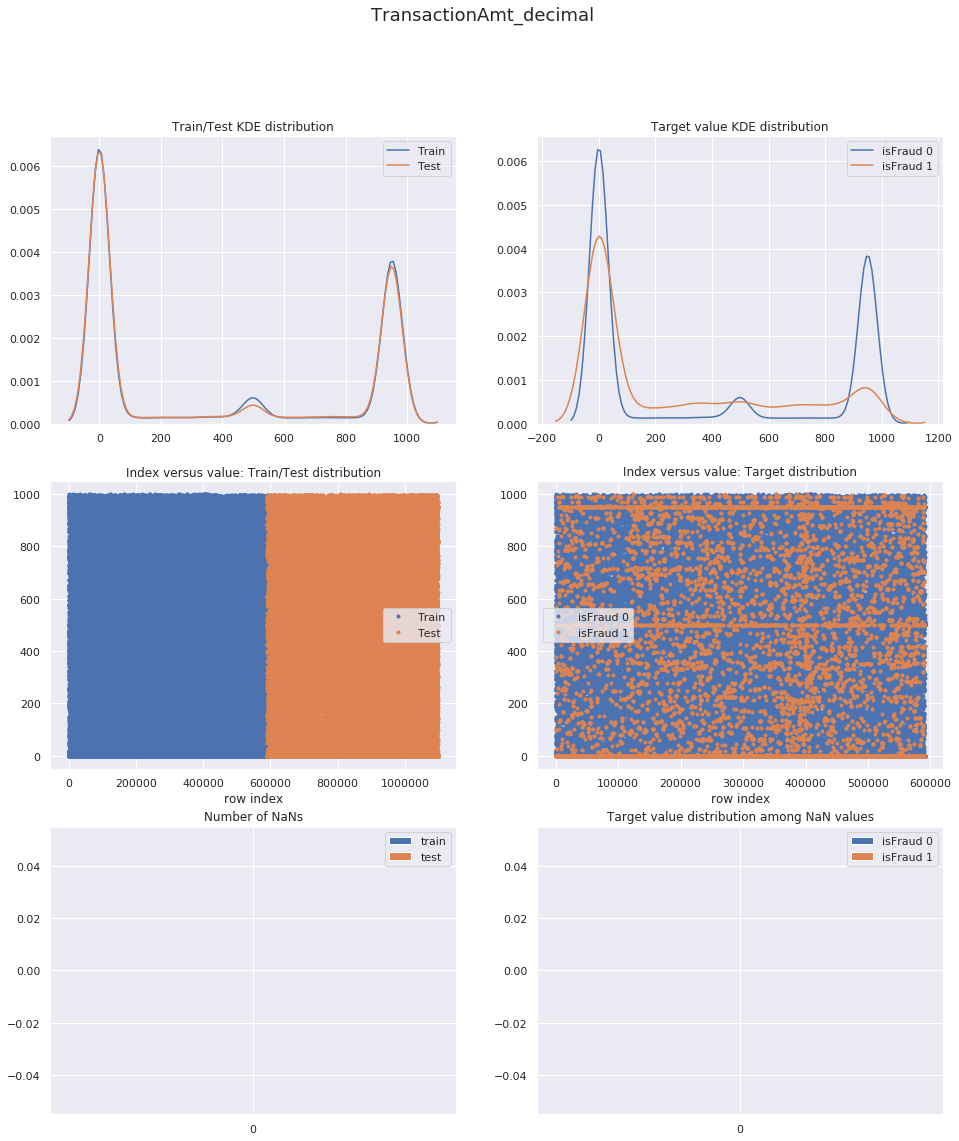

In [44]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)
plot_numerical('TransactionAmt_decimal')

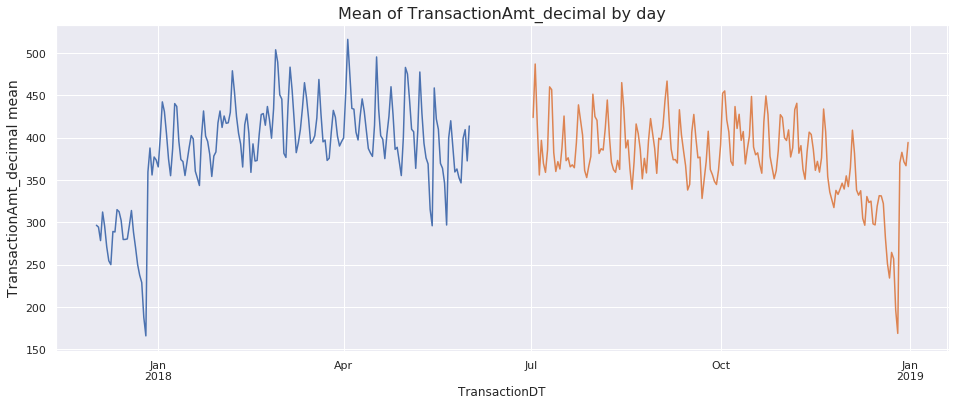

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt_decimal'].plot(ax=axes).set_ylabel('TransactionAmt_decimal mean', fontsize=14);
test.set_index('TransactionDT').resample('D').mean()['TransactionAmt_decimal'].plot(ax=axes).set_ylabel('TransactionAmt_decimal mean', fontsize=14);
axes.set_title('Mean of TransactionAmt_decimal by day', fontsize=16);

A relationship between mean of TransactionAmt_decimal by day and a mean of isFraud by day.

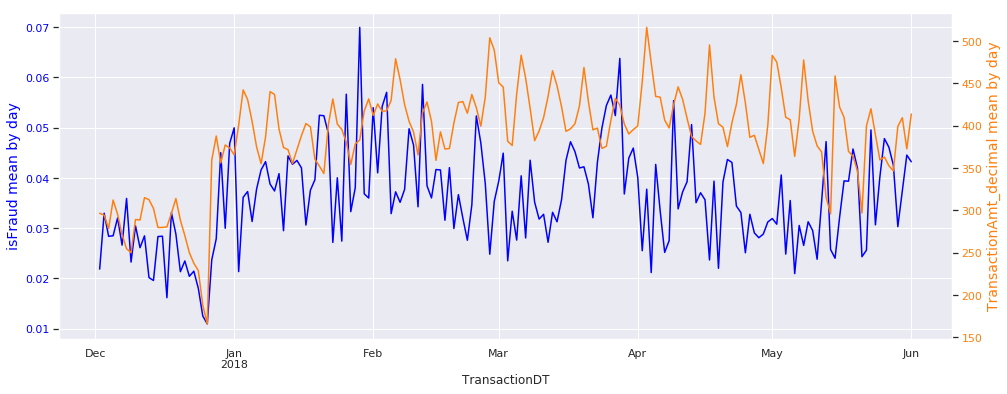

In [46]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean by day', color='blue', fontsize=14)
ax2 = ax1.twinx()
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt_decimal'].plot(ax=ax2, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('TransactionAmt_decimal mean by day', color='tab:orange', fontsize=14);
ax2.grid(False)

# V1

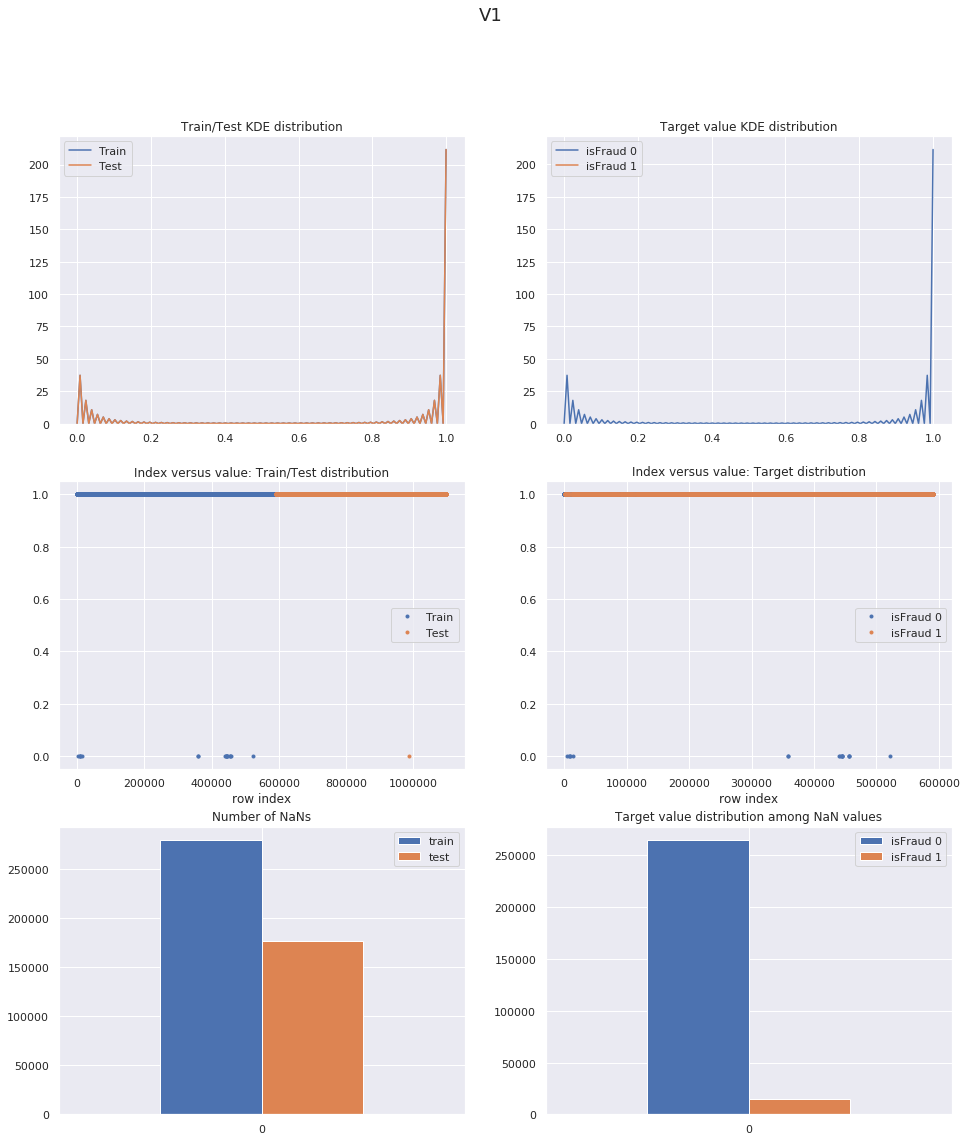

In [47]:
plot_numerical('V1')

In [48]:
print('Covariate shift:', covariate_shift('V1'))

Covariate shift: 0.5617312780270574


# V2

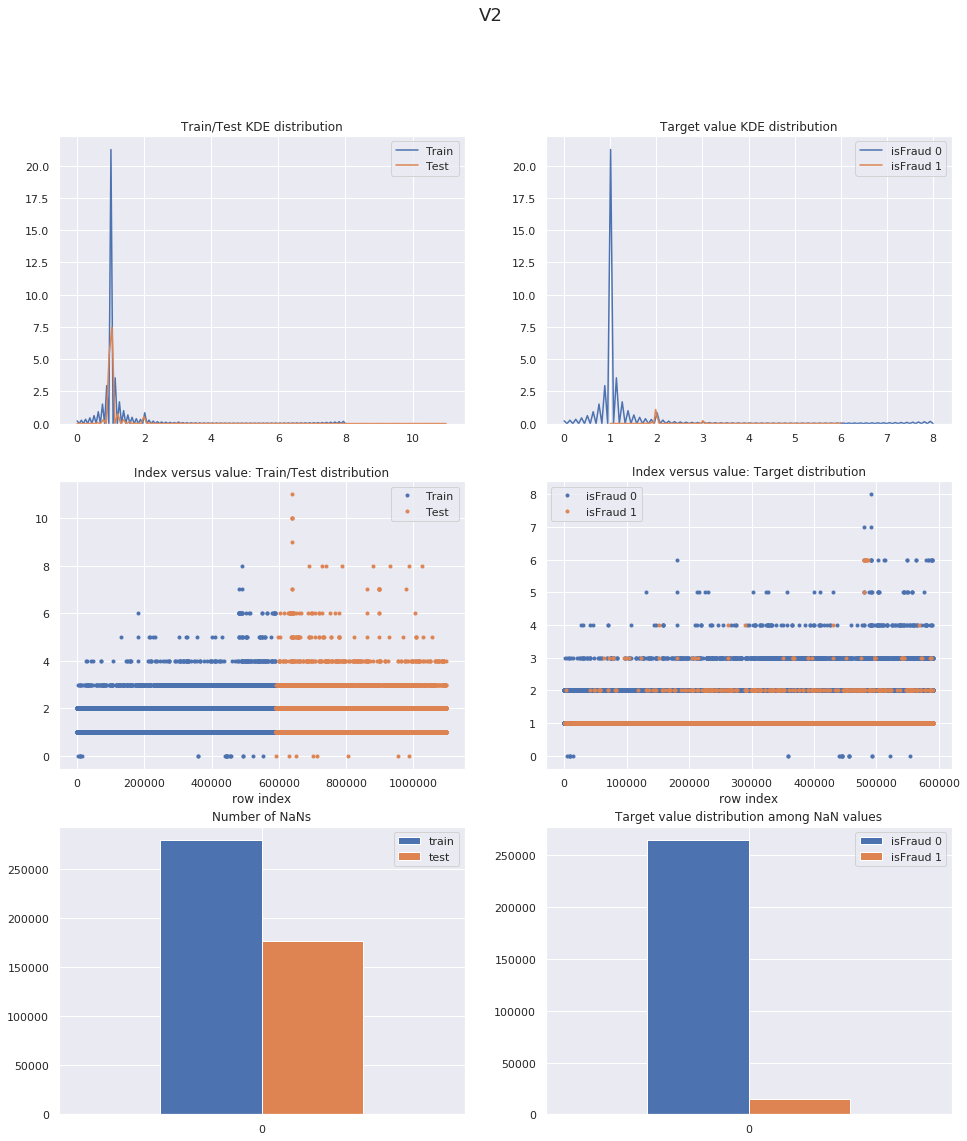

In [49]:
plot_numerical('V2')

In [50]:
print('Covariate shift:', covariate_shift('V2'))

Covariate shift: 0.561965049205892


# V3

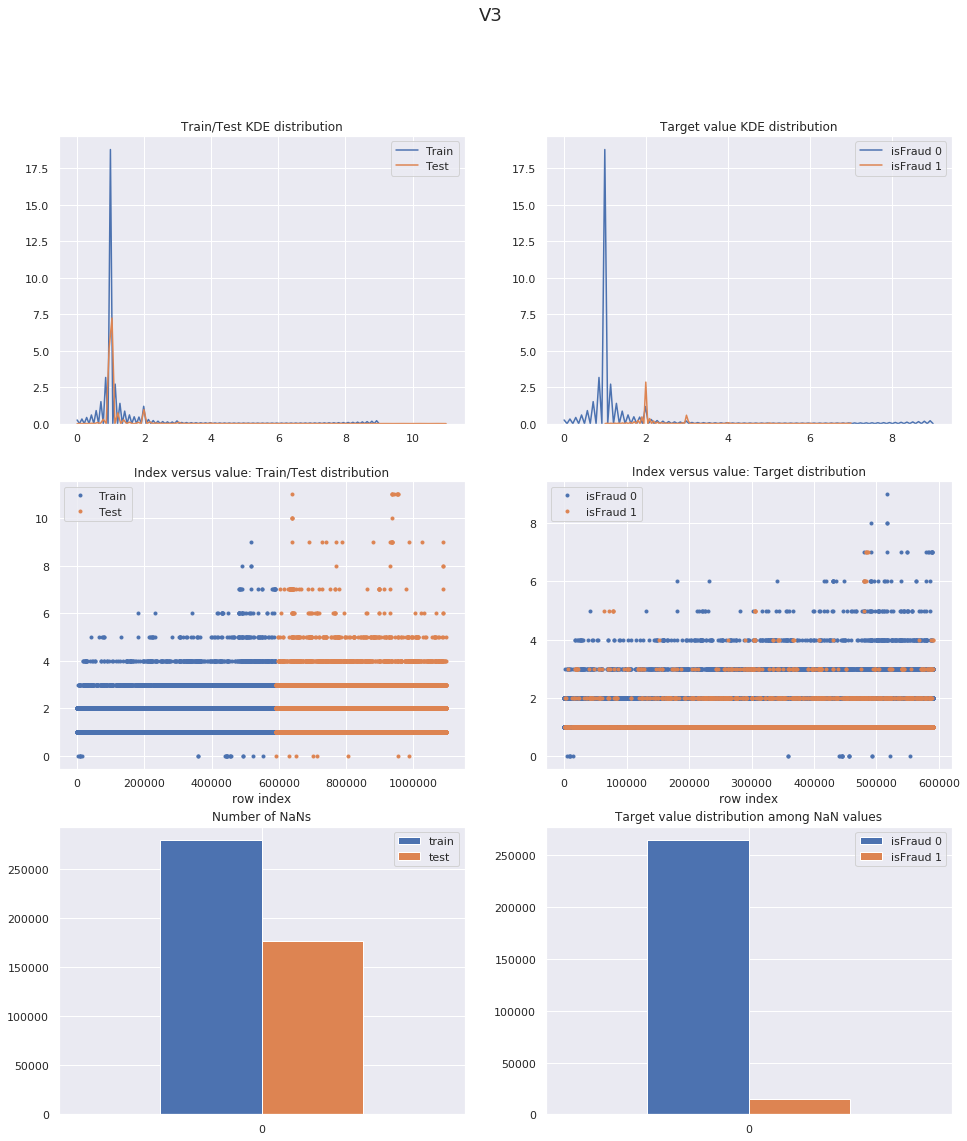

In [51]:
plot_numerical('V3')

In [52]:
print('Covariate shift:', covariate_shift('V3'))

Covariate shift: 0.5623831426057877


# V4

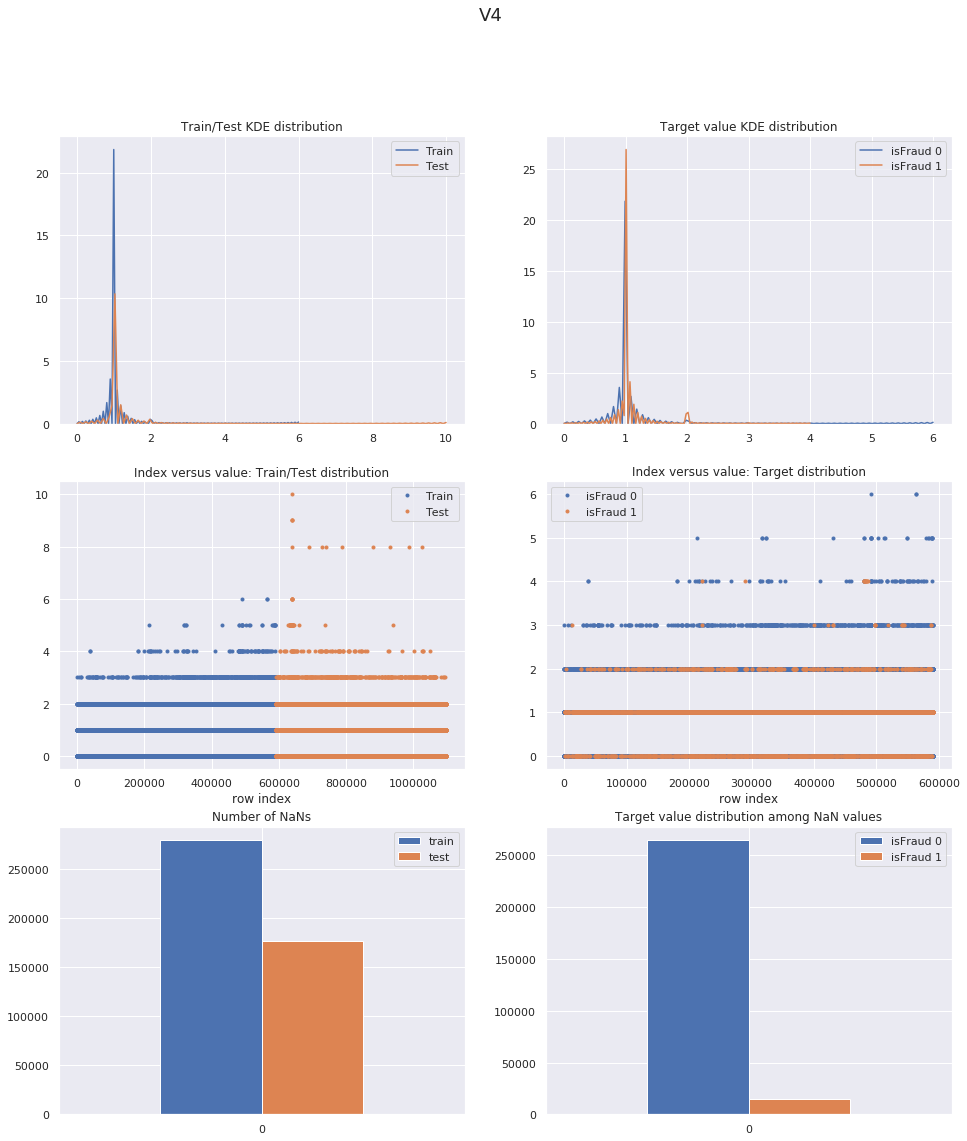

In [53]:
plot_numerical('V4')

In [54]:
print('Covariate shift:', covariate_shift('V4'))

Covariate shift: 0.563795271271095


# V5

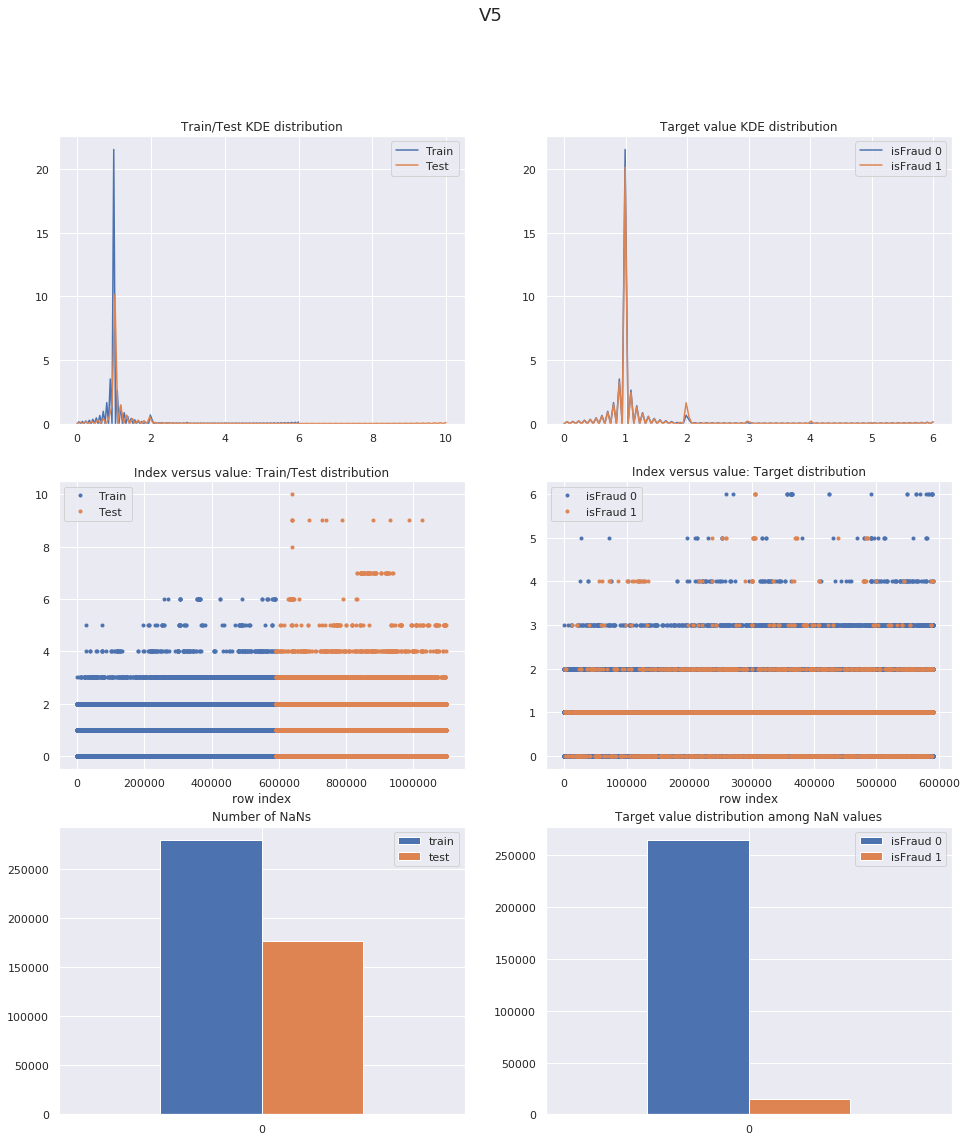

In [55]:
plot_numerical('V5')

In [56]:
print('Covariate shift:', covariate_shift('V5'))

Covariate shift: 0.5630419440028669


# V6

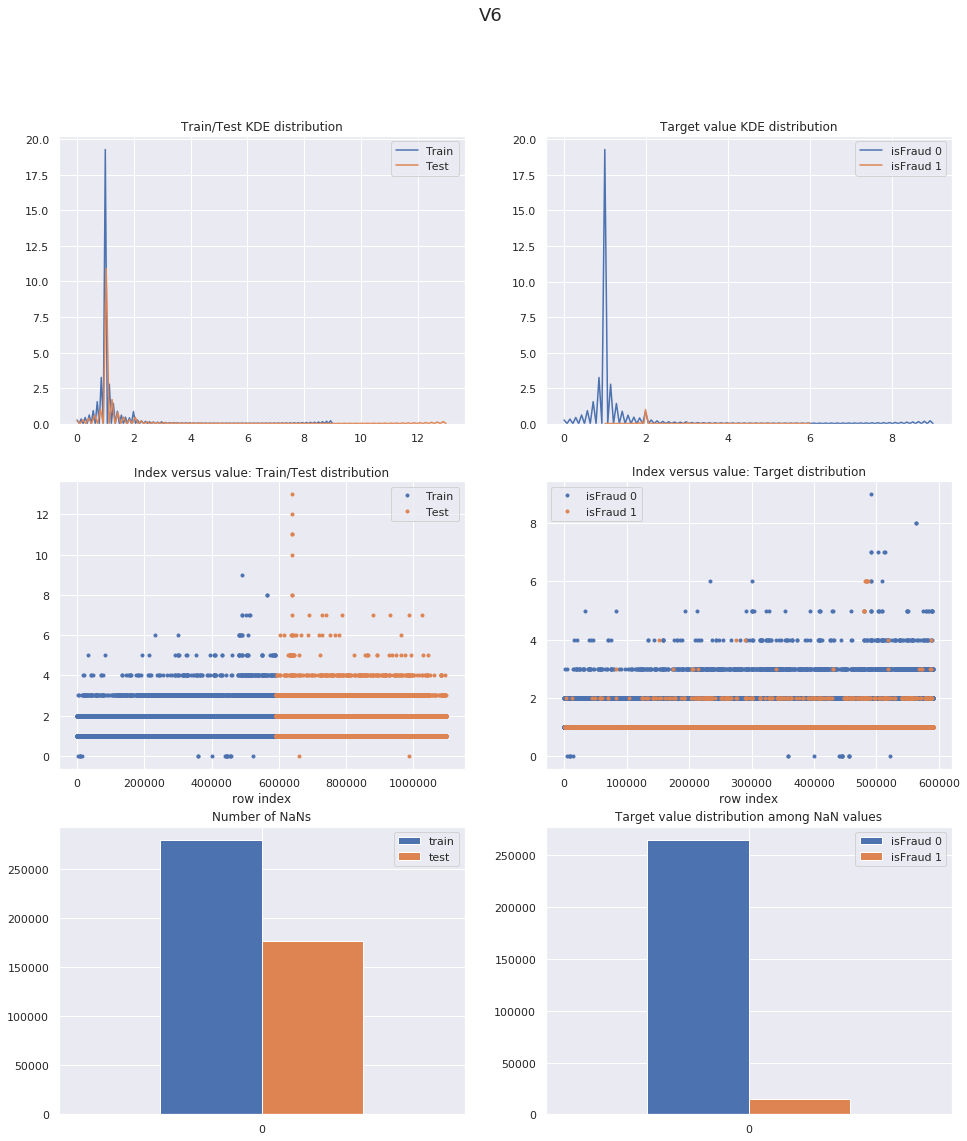

In [57]:
plot_numerical('V6')

In [58]:
print('Covariate shift:', covariate_shift('V6'))

Covariate shift: 0.5617925177822714


# V7

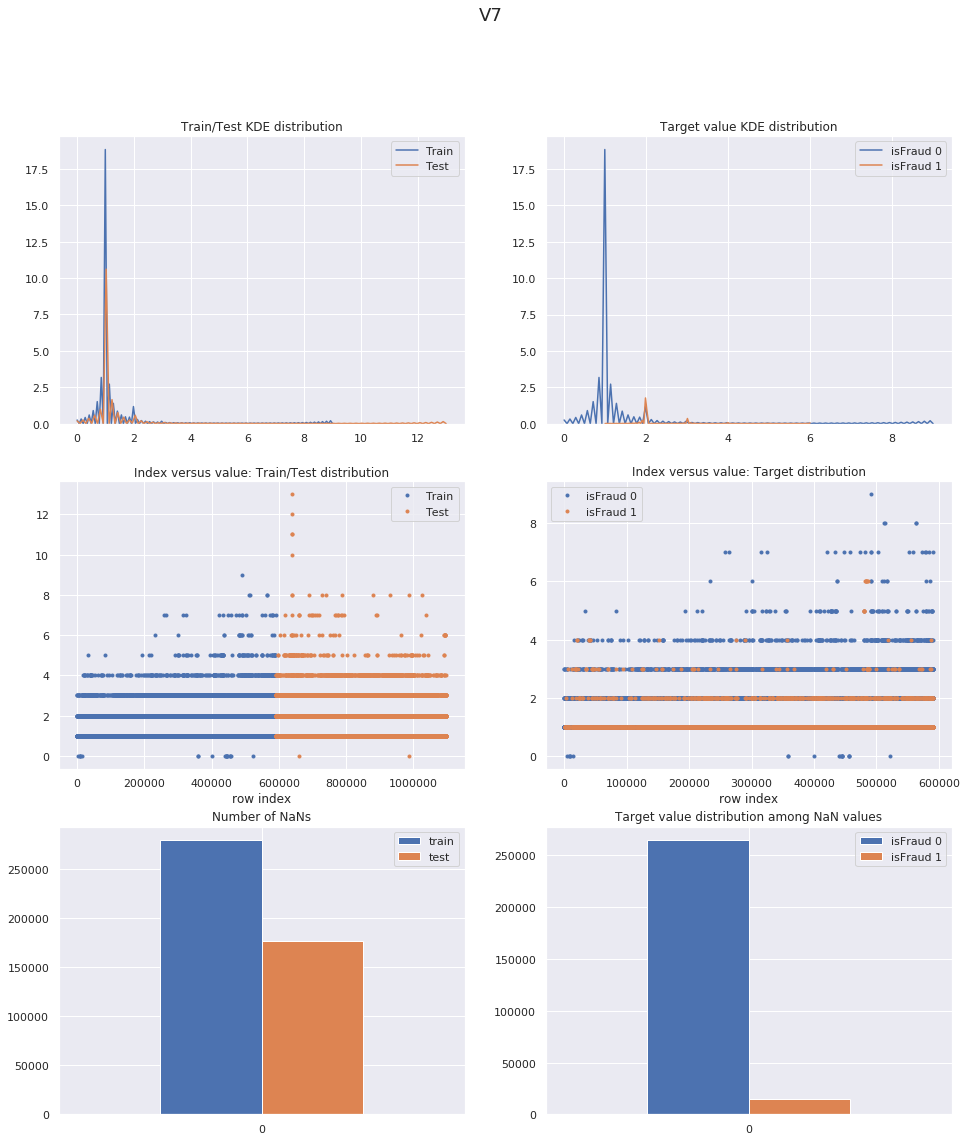

In [59]:
plot_numerical('V7')

In [60]:
print('Covariate shift:', covariate_shift('V7'))

Covariate shift: 0.5621310557757165


# V258

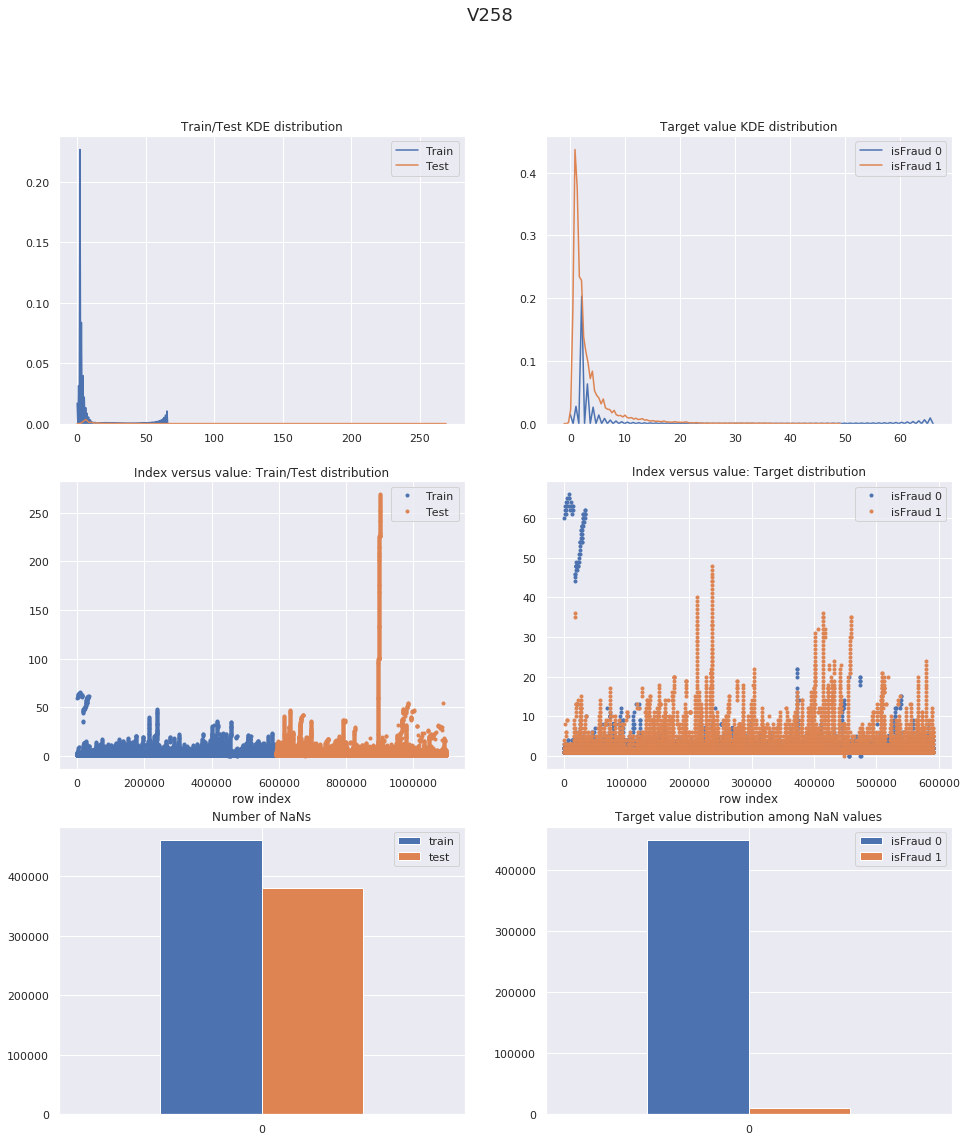

In [61]:
plot_numerical('V258')

In [62]:
print('Covariate shift:', covariate_shift('V258'))

Covariate shift: 0.5153350497369947


# V294

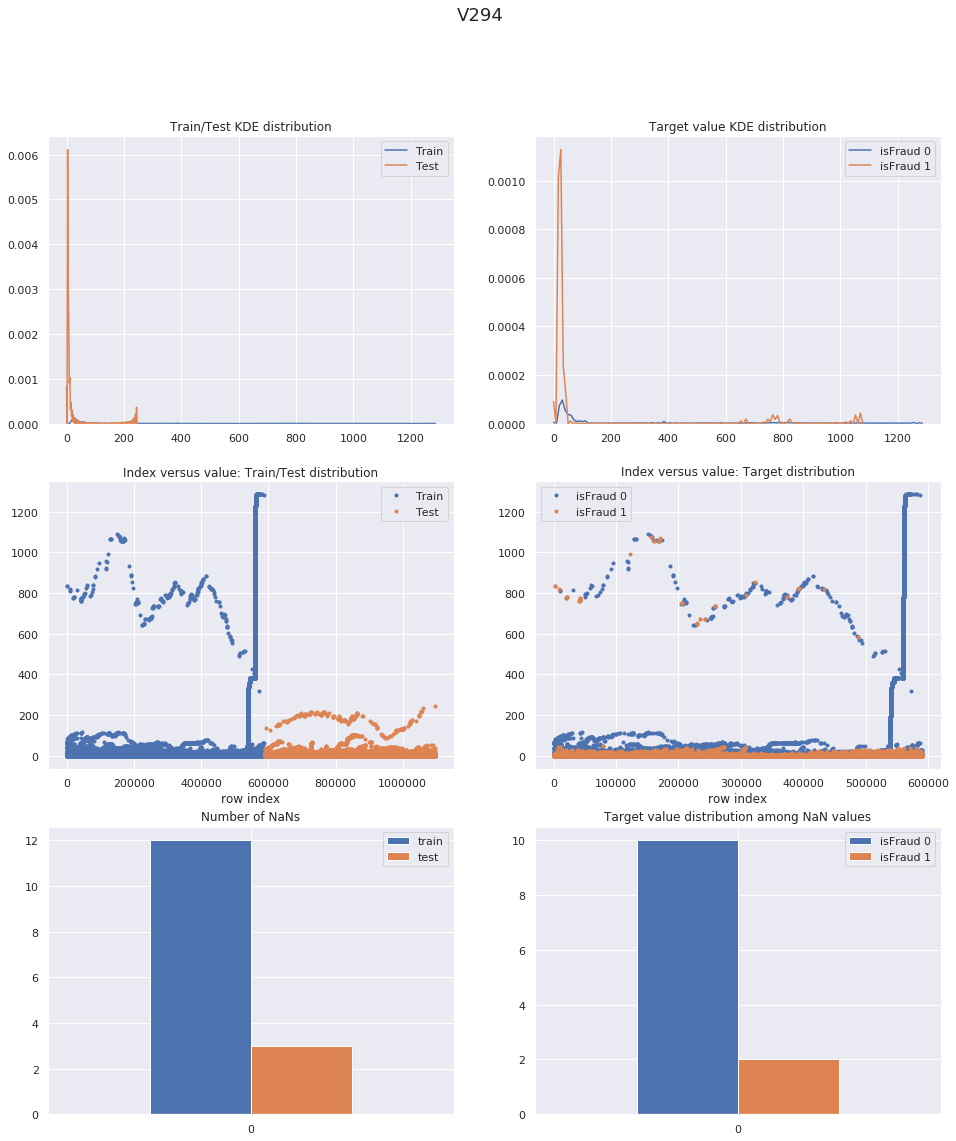

In [63]:
plot_numerical('V294')

In [64]:
print('Covariate shift:', covariate_shift('V294'))

Covariate shift: 0.5073842432471619


# C1

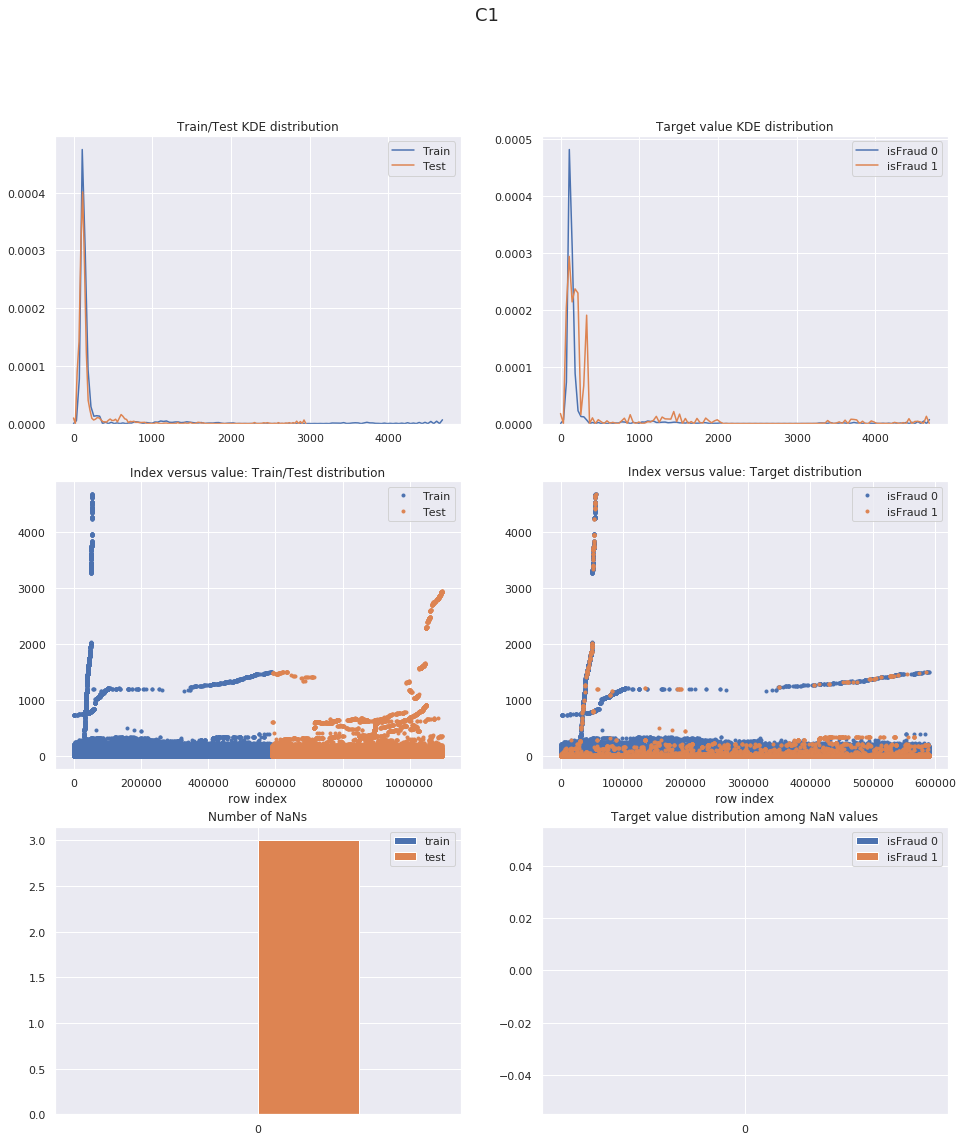

In [65]:
plot_numerical('C1')

In [66]:
print('Covariate shift:', covariate_shift('C1'))

Covariate shift: 0.5181248850570104


# C2

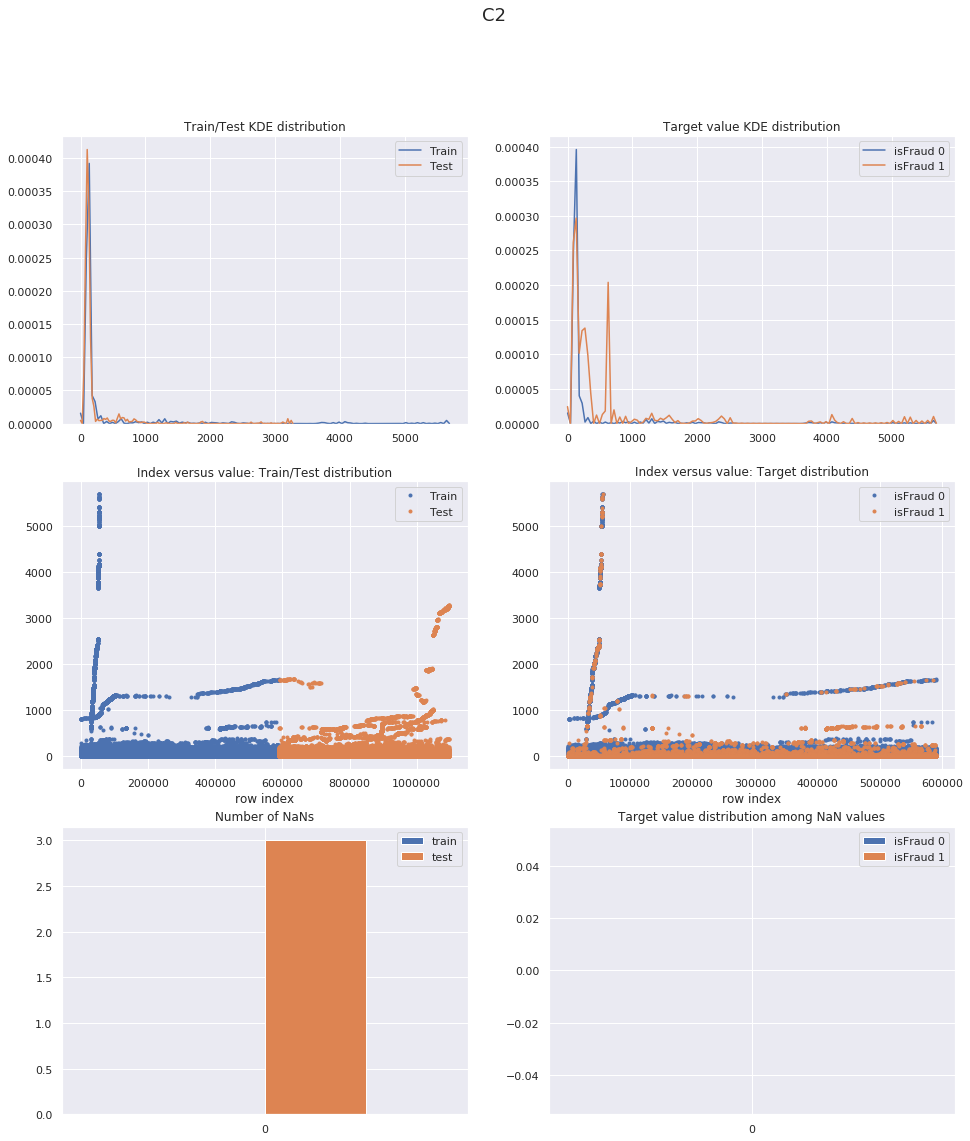

In [67]:
plot_numerical('C2')

In [68]:
print('Covariate shift:', covariate_shift('C2'))

Covariate shift: 0.518648419532034


# C3

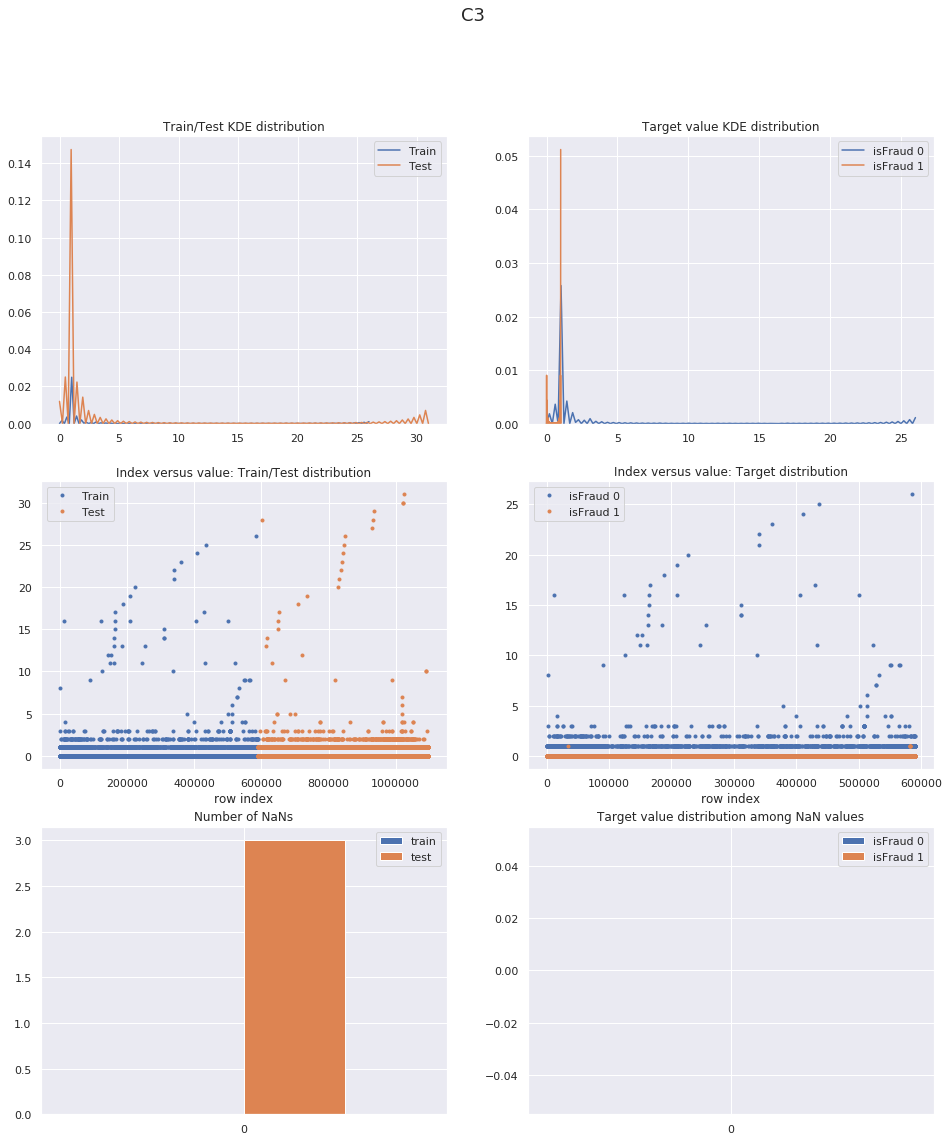

In [69]:
plot_numerical('C3')

In [70]:
print('Covariate shift:', covariate_shift('C3'))

Covariate shift: 0.5107250988635688


# C13

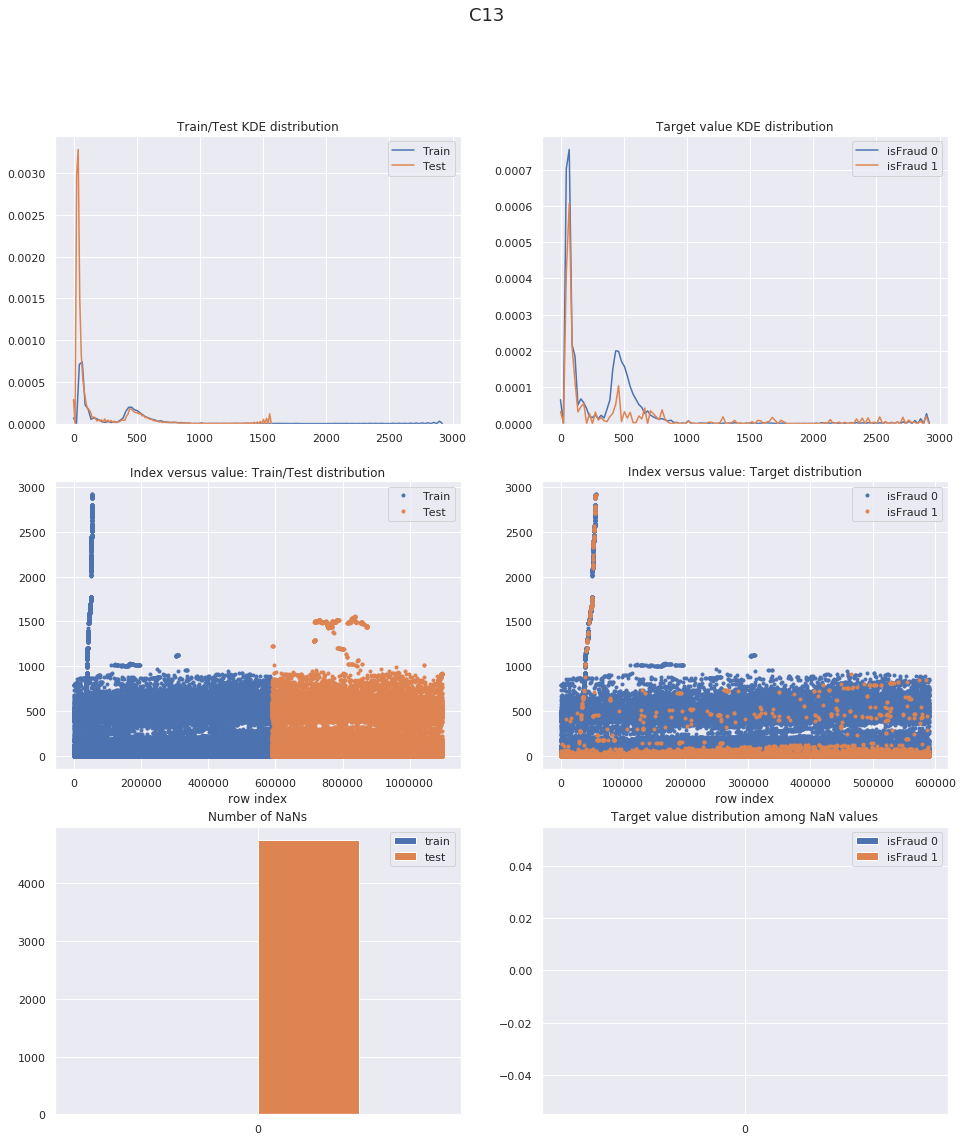

In [71]:
plot_numerical('C13')

# C14

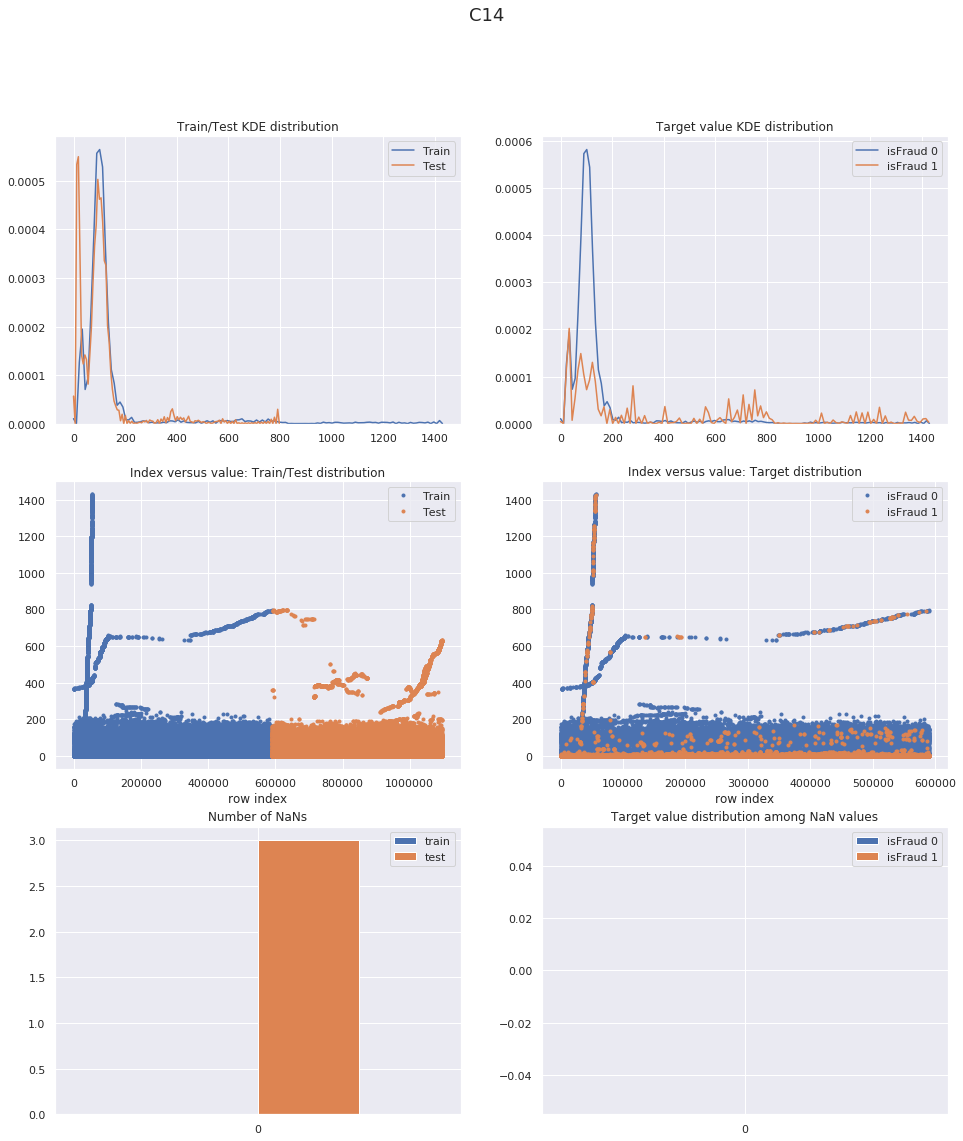

In [72]:
plot_numerical('C14')

# id_31

In [73]:
print('Covariate shift:', covariate_shift('id_31'))

Covariate shift: 0.6812747910333805
